# Demonstration of distribution reweighting

    xgboost is used to train the data and mc sample.
    data is shuffled before divided into train test and validation part
    root_numpy and pandas are used to hadle root files.
    sklearn is partly used.

In [1]:
%pylab inline
figsize(16, 8)

from __future__ import division
import xgboost as xgb 
from xgboost import plot_importance
from xgboost import plot_tree
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import metrics
import pandas as pd
import root_numpy

Populating the interactive namespace from numpy and matplotlib
Welcome to JupyROOT 6.12/04


In [2]:
hist_settings = {'bins': 100, 'normed': True, 'alpha': 0.5}
def draw_distributions(original, target, new_original_weights, fig_name):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    for id, column in enumerate(columns_draw, 1):
        xlim = numpy.percentile(numpy.hstack([target[column]]), [0.01, 99.99]) #percentile is to calculate the p% number of a givening array
        ax=plt.subplot(6, 5, id) 
        hist(target[column], range=xlim, **hist_settings)
        hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)  #hist is to plot the histogram (matplotlib)
        
        plt.title(columns_draw[id-1],fontsize=20)
        tight_layout() #distance between different figs
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        # 设置坐标标签字体大小
        #ax.set_xlabel('', fontsize=20)
        #ax.set_ylabel('', fontsize=20)
        # 设置图例字体大小
        #ax.legend('', fontsize=20)    
    savefig(fig_name)

## Prepare for data
    

In [3]:
columns_draw = ['ct_g','ct_eta','Px_g','Py_g','Pz_g','E_g','Px_eta','Py_eta','Pz_eta','E_eta','Px_pi01','Py_pi01','Pz_pi01','E_pi01','Px_pi02','Py_pi02',
           'Pz_pi02','E_pi02','Metapi01','Metapi02','Mpi01pi02','Metapi01pi02',
           'Mgeta','Mgpi01','Mgpi02','Mgetapi01','Mgetapi02']
phsp_ori_draw = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MC_cut_final.root', treename='final',branches=columns_draw)
phsp_10w_draw = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MC_train20w_final.root', treename='final',branches=columns_draw)
data_ori_draw = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/DIY_after_final.root',treename='final', branches=columns_draw)
mctruth_ori_draw = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MCtruth_final.root', treename='final',branches=columns_draw)
DIY_truth_all_draw = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MCtruth_forDIY_all_final.root', treename='final',branches=columns_draw)

In [4]:
#columns = ['Px_g','Py_g','Pz_g','E_g','Px_eta','Py_eta','Pz_eta','E_eta','Px_pi01','Py_pi01','Pz_pi01','E_pi01','Px_pi02','Py_pi02',
#           'Pz_pi02','E_pi02','Metapi01','Metapi02','Mpi01pi02','Metapi01pi02',
#           'Mgeta','Mgpi01','Mgpi02','Mgetapi01','Mgetapi02']
columns = ['ct_g','ct_eta','Metapi01','Metapi02','Mpi01pi02','Mgeta','Mgpi01']
#columns = ['p_px','p_py','p_pz','p_e','pi_px','pi_py','pi_pz','pi_e','ppi_mass', 'pn_mass','npi_mass']
phsp_ori = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MC_cut_final.root', treename='final',branches=columns)
phsp_10w = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MC_train20w_final.root', treename='final',branches=columns)
data_ori = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/DIY_after_final.root',treename='final', branches=columns)
mctruth_ori = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MCtruth_final.root', treename='final',branches=columns)
DIY_truth_all = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MCtruth_forDIY_all_final.root', treename='final',branches=columns)

data_only_X=pd.DataFrame(data_ori)
phsp_only_X=pd.DataFrame(phsp_ori)
phsp_10w_X=pd.DataFrame(phsp_10w)
mctruth_only_X=pd.DataFrame(mctruth_ori)
DIY_truth_all_X=pd.DataFrame(DIY_truth_all)

data_only_Y=numpy.ones(len(data_only_X))
phsp_only_Y=numpy.zeros(len(phsp_only_X))
phsp_10w_Y=numpy.zeros(len(phsp_10w_X))
mctruth_only_Y=numpy.zeros(len(mctruth_only_X))
DIY_truth_all_Y=numpy.zeros(len(DIY_truth_all_X))

phsp=pd.DataFrame(phsp_ori)
phsp_10w=pd.DataFrame(phsp_10w)
data=pd.DataFrame(data_ori)
original_weights=numpy.ones(len(phsp_ori))
#for MC truth information

mctruth=pd.DataFrame(mctruth_ori)
mctruth_weights=numpy.ones(len(mctruth_ori))

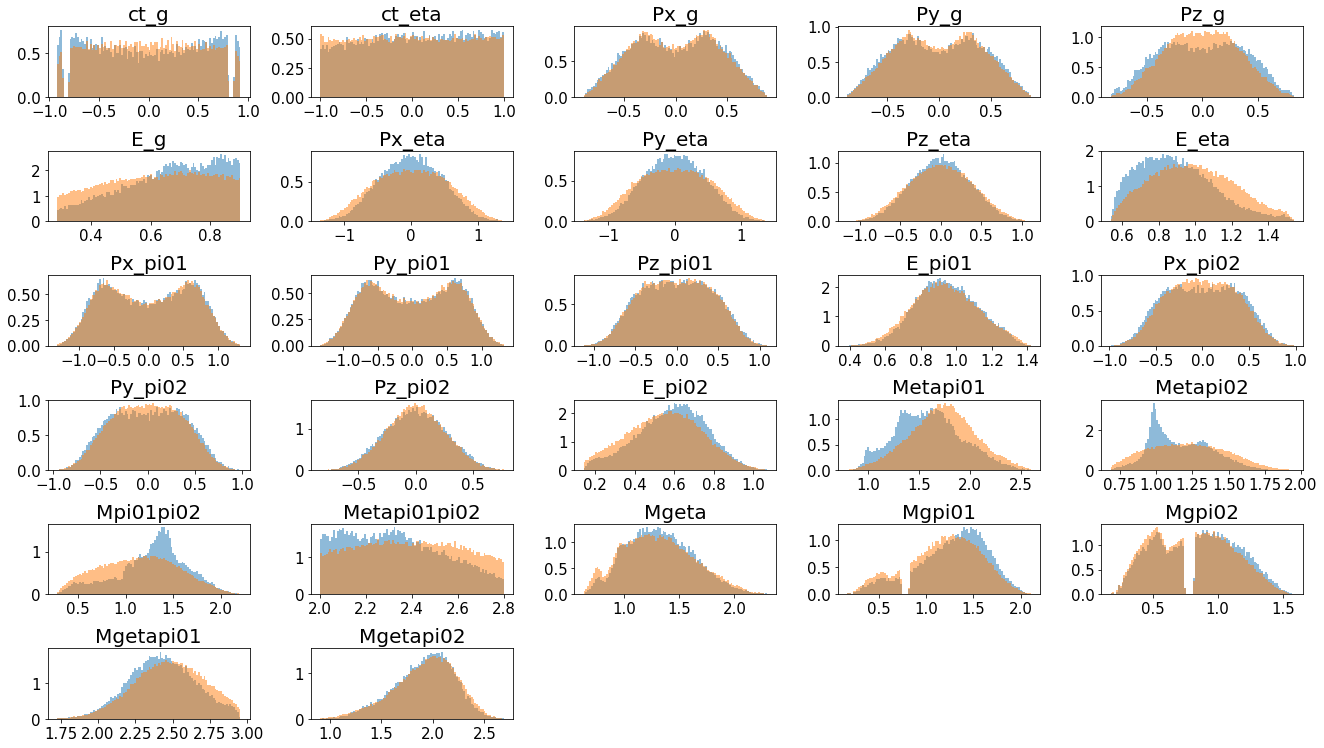

In [5]:
#original distribution before reweighting
draw_distributions(phsp_ori_draw, data_ori_draw,original_weights,'phsp_target_ori.pdf')  

In [6]:
#tanslate to array format
phsp_10w_a=np.array(phsp_10w)
data_a=np.array(data)
phsp_only_X=np.array(phsp)
mctruth_only_X=np.array(mctruth)
DIY_truth_all_X=np.array(DIY_truth_all_X)

from sklearn.cross_validation import train_test_split
data_train, data_test = train_test_split(data_a,test_size=0)
phsp_train, phsp_test1 = train_test_split(phsp_10w,train_size=data_train.shape[0]) #get the same number of mc with data

data_all = numpy.concatenate([data_train, phsp_train])
labels_all = numpy.array([1] * len(data_train) + [0] * len(phsp_train))

train_X, test_X,train_Y, test_Y= train_test_split(data_all,labels_all,test_size=0.3)
#print data_all,data_all.shape
#print labels_all,labels_all.shape

/home/xiongxa/.conda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Initial the xgboost

In [7]:
xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)
#xg_val = xgb.DMatrix(val_X, label=val_Y)
xg_data_only = xgb.DMatrix(data_only_X, label=data_only_Y)
xg_phsp_only = xgb.DMatrix(phsp_only_X, label=phsp_only_Y)
xg_mctruth_only = xgb.DMatrix(mctruth_only_X, label=mctruth_only_Y)
xg_DIY_truth_all = xgb.DMatrix(DIY_truth_all_X, label=DIY_truth_all_Y)

'''
params={
'booster':'gbtree',
'silent':0 ,#设置成1则没有运行信息输出，最好是设置为0.
#'nthread':7,# cpu 线程数 默认最大
'eta': 0.007, # 如同学习率
'min_child_weight':3, 
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
'max_depth':6, # 构建树的深度，越大越容易过拟合
'gamma':0.1,  # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
'subsample':0.7, # 随机采样训练样本
'colsample_bytree':0.7, # 生成树时进行的列采样 
'lambda':2,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
#'alpha':0, # L1 正则项参数
#'scale_pos_weight':1, #如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。
#'objective': 'multi:softmax', #多分类的问题
'num_class':2, # 类别数，多分类与 multisoftmax 并用
'seed':1000, #随机种子
#'eval_metric': 'auc'
}
'''

# setup parameters for xgboost
params = {}
# use softmax multi-class classification
params['objective'] = 'multi:softmax'
# scale weight of positive examples
params['eta'] = 0.1
params['max_depth'] = 7
params['silent'] = 1
params['nthread'] = 4
params['num_class'] = 2

# do the same thing again, but output probabilities
params['objective'] = 'multi:softprob'
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 200 # 迭代次数
bst = xgb.train(params, xg_train, num_round, watchlist)

[0]	train-merror:0.332184	test-merror:0.347863
[1]	train-merror:0.329103	test-merror:0.347461
[2]	train-merror:0.327637	test-merror:0.347712
[3]	train-merror:0.325547	test-merror:0.348316
[4]	train-merror:0.325849	test-merror:0.347914
[5]	train-merror:0.325181	test-merror:0.346858
[6]	train-merror:0.325224	test-merror:0.348165
[7]	train-merror:0.323177	test-merror:0.347511
[8]	train-merror:0.322509	test-merror:0.346908
[9]	train-merror:0.322358	test-merror:0.346405
[10]	train-merror:0.32225	test-merror:0.346858
[11]	train-merror:0.321906	test-merror:0.345148
[12]	train-merror:0.320764	test-merror:0.346003
[13]	train-merror:0.319794	test-merror:0.345701
[14]	train-merror:0.319492	test-merror:0.344997
[15]	train-merror:0.318803	test-merror:0.344947
[16]	train-merror:0.317747	test-merror:0.344847
[17]	train-merror:0.31695	test-merror:0.344997
[18]	train-merror:0.315592	test-merror:0.344796
[19]	train-merror:0.315269	test-merror:0.343942
[20]	train-merror:0.31445	test-merror:0.344243
[21]	

[171]	train-merror:0.259783	test-merror:0.344545
[172]	train-merror:0.259115	test-merror:0.344545
[173]	train-merror:0.258533	test-merror:0.344545
[174]	train-merror:0.258231	test-merror:0.345048
[175]	train-merror:0.257994	test-merror:0.344746
[176]	train-merror:0.257865	test-merror:0.344696
[177]	train-merror:0.257671	test-merror:0.344495
[178]	train-merror:0.257305	test-merror:0.344796
[179]	train-merror:0.257326	test-merror:0.344796
[180]	train-merror:0.256723	test-merror:0.345048
[181]	train-merror:0.256572	test-merror:0.344847
[182]	train-merror:0.256507	test-merror:0.344947
[183]	train-merror:0.256141	test-merror:0.344595
[184]	train-merror:0.25612	test-merror:0.344595
[185]	train-merror:0.256077	test-merror:0.344545
[186]	train-merror:0.255344	test-merror:0.344897
[187]	train-merror:0.254568	test-merror:0.344545
[188]	train-merror:0.254396	test-merror:0.344746
[189]	train-merror:0.254417	test-merror:0.344696
[190]	train-merror:0.254482	test-merror:0.344595
[191]	train-merror:0.

In [8]:
pred_prob = bst.predict(xg_test).reshape(test_Y.shape[0], 2)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != test_Y) / test_Y.shape[0]
#print pred_prob
#print pred_label[0:20], test_Y[0:20] ,error_rate
print('Test error using softprob = {}'.format(error_rate))

Test error using softprob = 0.344544997486


In [9]:
pr_test=np.array(bst.predict(xg_test).reshape(test_Y.shape[0], 2))
#pr_val=np.array(bst.predict(xg_val).reshape(val_Y.shape[0], 2))
pr_phsp=np.array(bst.predict(xg_phsp_only).reshape(phsp_only_Y.shape[0], 2))
pr_mctruth=np.array(bst.predict(xg_mctruth_only).reshape(mctruth_only_Y.shape[0], 2))

weight_test=pr_test[:,1]/pr_test[:,0]
#weight_val=pr_val[:,1]/pr_val[:,0]
weight_phsp=pr_phsp[:,1]/pr_phsp[:,0]
weight_mctruth=pr_mctruth[:,1]/pr_mctruth[:,0]

print 'The efficiency is = ',weight_phsp.sum()/weight_mctruth.sum()

The efficiency is =  0.31248516


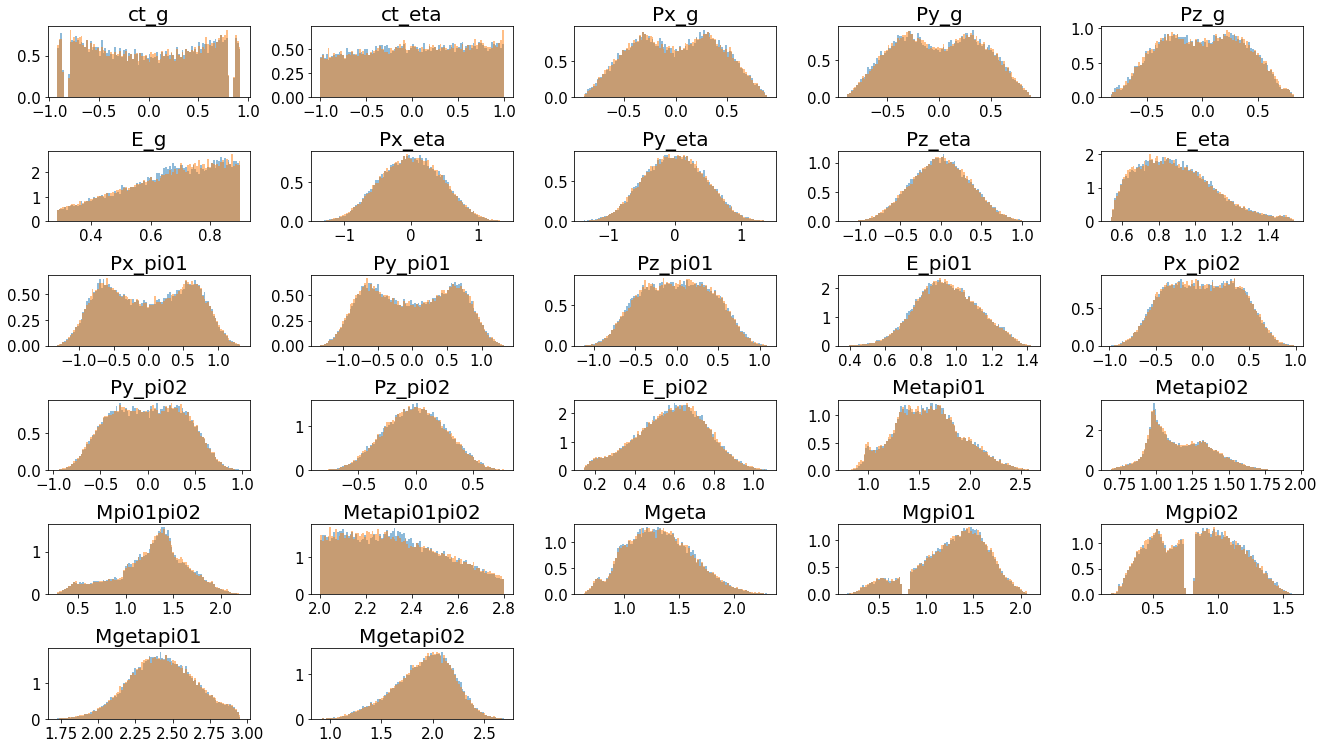

In [10]:
draw_distributions(phsp_ori_draw, data_ori_draw,weight_phsp,'phsp_target_xgboost.pdf')

In [11]:
#10 fold cross validation
from sklearn.model_selection import KFold,GridSearchCV
Error=[]
Effi=[]
randn=np.random.RandomState(22222)
kf=KFold(n_splits=10,shuffle=True,random_state=randn)
for train_index, test_index in kf.split(train_X):
    xgk_train = xgb.DMatrix(train_X[train_index], label=train_Y[train_index])
    xgk_test = xgb.DMatrix(train_X[test_index], label=train_Y[test_index])
    
    print train_X[train_index],train_Y[train_index]
    # setup parameters for xgboost
    params = {}
    # use softmax multi-class classification
    params['objective'] = 'multi:softmax'
    # scale weight of positive examples
    params['eta'] = 0.1
    params['max_depth'] = 6
    params['silent'] = 1
    params['nthread'] = 4
    params['num_class'] = 2

    # do the same thing again, but output probabilities
    params['objective'] = 'multi:softprob'
    watchlist = [(xgk_train, 'train'), (xgk_test, 'test')]
    num_round = 200 # 迭代次数
    bst = xgb.train(params, xgk_train, num_round, watchlist)
    
    pred_prob = bst.predict(xgk_test).reshape(train_Y[test_index].shape[0], 2)
    pred_label = np.argmax(pred_prob, axis=1)
    error_rate = np.sum(pred_label != train_Y[test_index]) / train_Y[test_index].shape[0]
    
    pr_test=np.array(bst.predict(xg_test).reshape(test_Y.shape[0], 2))
    pr_phsp=np.array(bst.predict(xg_phsp_only).reshape(phsp_only_Y.shape[0], 2))
    pr_mctruth=np.array(bst.predict(xg_mctruth_only).reshape(mctruth_only_Y.shape[0], 2))
    
    weight_test=pr_test[:,1]/pr_test[:,0]
    weight_phsp=pr_phsp[:,1]/pr_phsp[:,0]
    weight_mctruth=pr_mctruth[:,1]/pr_mctruth[:,0]
    
    Error.append(error_rate);
    Effi.append(weight_phsp.sum()/weight_mctruth.sum());

[[ 0.48104405  0.94143915  1.6322393  ...  0.82395107  2.1554136
   0.44121748]
 [-0.618373   -0.952609    2.3810391  ...  0.7622361   0.6911186
   1.4588482 ]
 [ 0.21907218  0.50598294  2.1975465  ...  0.9042129   1.6442597
   1.006846  ]
 ...
 [-0.46779794 -0.36489823  1.3495015  ...  1.1363215   1.2897372
   1.6011968 ]
 [ 0.67780167 -0.610298    1.6499158  ...  1.0358853   1.2027371
   1.5474819 ]
 [-0.12447308 -0.8990955   1.426756   ...  1.8149122   0.75470495
   1.3150889 ]] [1 0 0 ... 1 1 1]
[0]	train-merror:0.342591	test-merror:0.353157
[1]	train-merror:0.339479	test-merror:0.351648
[2]	train-merror:0.339048	test-merror:0.351648
[3]	train-merror:0.339072	test-merror:0.350356
[4]	train-merror:0.336294	test-merror:0.347123
[5]	train-merror:0.337276	test-merror:0.347554
[6]	train-merror:0.332296	test-merror:0.340875
[7]	train-merror:0.331673	test-merror:0.341521
[8]	train-merror:0.332727	test-merror:0.341737
[9]	train-merror:0.332272	test-merror:0.34303
[10]	train-merror:0.331027

[160]	train-merror:0.280221	test-merror:0.334842
[161]	train-merror:0.280221	test-merror:0.334842
[162]	train-merror:0.279838	test-merror:0.335488
[163]	train-merror:0.279814	test-merror:0.335273
[164]	train-merror:0.279742	test-merror:0.335704
[165]	train-merror:0.279287	test-merror:0.336134
[166]	train-merror:0.27924	test-merror:0.335919
[167]	train-merror:0.27924	test-merror:0.335704
[168]	train-merror:0.278354	test-merror:0.336134
[169]	train-merror:0.278354	test-merror:0.336134
[170]	train-merror:0.278306	test-merror:0.336134
[171]	train-merror:0.278306	test-merror:0.335704
[172]	train-merror:0.278234	test-merror:0.335704
[173]	train-merror:0.277779	test-merror:0.335057
[174]	train-merror:0.277372	test-merror:0.336565
[175]	train-merror:0.276726	test-merror:0.336996
[176]	train-merror:0.27663	test-merror:0.337643
[177]	train-merror:0.276462	test-merror:0.338074
[178]	train-merror:0.276223	test-merror:0.337427
[179]	train-merror:0.276079	test-merror:0.337427
[180]	train-merror:0.27

[120]	train-merror:0.293701	test-merror:0.335273
[121]	train-merror:0.293342	test-merror:0.335273
[122]	train-merror:0.293222	test-merror:0.335704
[123]	train-merror:0.293126	test-merror:0.335704
[124]	train-merror:0.292982	test-merror:0.335488
[125]	train-merror:0.292384	test-merror:0.335273
[126]	train-merror:0.291929	test-merror:0.335273
[127]	train-merror:0.291881	test-merror:0.334842
[128]	train-merror:0.291666	test-merror:0.335273
[129]	train-merror:0.291474	test-merror:0.334626
[130]	train-merror:0.290876	test-merror:0.334411
[131]	train-merror:0.290469	test-merror:0.334626
[132]	train-merror:0.290493	test-merror:0.334626
[133]	train-merror:0.290445	test-merror:0.334842
[134]	train-merror:0.290397	test-merror:0.334842
[135]	train-merror:0.290157	test-merror:0.334842
[136]	train-merror:0.289391	test-merror:0.334842
[137]	train-merror:0.288697	test-merror:0.334411
[138]	train-merror:0.288697	test-merror:0.334195
[139]	train-merror:0.288673	test-merror:0.334195
[140]	train-merror:0

[80]	train-merror:0.302966	test-merror:0.341952
[81]	train-merror:0.302727	test-merror:0.342599
[82]	train-merror:0.302655	test-merror:0.342814
[83]	train-merror:0.302081	test-merror:0.343891
[84]	train-merror:0.301937	test-merror:0.344107
[85]	train-merror:0.301674	test-merror:0.34346
[86]	train-merror:0.301195	test-merror:0.343676
[87]	train-merror:0.301099	test-merror:0.343891
[88]	train-merror:0.301003	test-merror:0.343676
[89]	train-merror:0.300596	test-merror:0.343245
[90]	train-merror:0.300117	test-merror:0.342383
[91]	train-merror:0.299926	test-merror:0.342814
[92]	train-merror:0.299255	test-merror:0.342599
[93]	train-merror:0.299231	test-merror:0.342599
[94]	train-merror:0.299064	test-merror:0.344753
[95]	train-merror:0.29904	test-merror:0.344538
[96]	train-merror:0.298896	test-merror:0.344322
[97]	train-merror:0.298633	test-merror:0.344107
[98]	train-merror:0.298034	test-merror:0.34303
[99]	train-merror:0.297939	test-merror:0.34303
[100]	train-merror:0.297675	test-merror:0.34

[40]	train-merror:0.312088	test-merror:0.33398
[41]	train-merror:0.311586	test-merror:0.33398
[42]	train-merror:0.311107	test-merror:0.33398
[43]	train-merror:0.31082	test-merror:0.333333
[44]	train-merror:0.310676	test-merror:0.333549
[45]	train-merror:0.310772	test-merror:0.333549
[46]	train-merror:0.310293	test-merror:0.333118
[47]	train-merror:0.309503	test-merror:0.334195
[48]	train-merror:0.30888	test-merror:0.333764
[49]	train-merror:0.308138	test-merror:0.333118
[50]	train-merror:0.307827	test-merror:0.333333
[51]	train-merror:0.307348	test-merror:0.333118
[52]	train-merror:0.30742	test-merror:0.333549
[53]	train-merror:0.306821	test-merror:0.333764
[54]	train-merror:0.306366	test-merror:0.333549
[55]	train-merror:0.305863	test-merror:0.332687
[56]	train-merror:0.305744	test-merror:0.332471
[57]	train-merror:0.305456	test-merror:0.332471
[58]	train-merror:0.305265	test-merror:0.333333
[59]	train-merror:0.305073	test-merror:0.333118
[60]	train-merror:0.304882	test-merror:0.33311

[1]	train-merror:0.339048	test-merror:0.348416
[2]	train-merror:0.338162	test-merror:0.345615
[3]	train-merror:0.336438	test-merror:0.34777
[4]	train-merror:0.336629	test-merror:0.346262
[5]	train-merror:0.3356	test-merror:0.346477
[6]	train-merror:0.334522	test-merror:0.346908
[7]	train-merror:0.333565	test-merror:0.346477
[8]	train-merror:0.332439	test-merror:0.343676
[9]	train-merror:0.329997	test-merror:0.343891
[10]	train-merror:0.329902	test-merror:0.342168
[11]	train-merror:0.328609	test-merror:0.341306
[12]	train-merror:0.327483	test-merror:0.339151
[13]	train-merror:0.326622	test-merror:0.340013
[14]	train-merror:0.326191	test-merror:0.339151
[15]	train-merror:0.32552	test-merror:0.338936
[16]	train-merror:0.325185	test-merror:0.34109
[17]	train-merror:0.324203	test-merror:0.338505
[18]	train-merror:0.323748	test-merror:0.337643
[19]	train-merror:0.322551	test-merror:0.336996
[20]	train-merror:0.32212	test-merror:0.33872
[21]	train-merror:0.321641	test-merror:0.337643
[22]	tra

[172]	train-merror:0.282759	test-merror:0.339582
[173]	train-merror:0.282089	test-merror:0.339151
[174]	train-merror:0.281849	test-merror:0.338936
[175]	train-merror:0.281299	test-merror:0.339151
[176]	train-merror:0.281155	test-merror:0.339151
[177]	train-merror:0.280461	test-merror:0.339797
[178]	train-merror:0.280413	test-merror:0.339797
[179]	train-merror:0.280149	test-merror:0.340013
[180]	train-merror:0.279958	test-merror:0.340013
[181]	train-merror:0.279599	test-merror:0.340013
[182]	train-merror:0.279551	test-merror:0.339582
[183]	train-merror:0.279072	test-merror:0.339797
[184]	train-merror:0.279048	test-merror:0.340013
[185]	train-merror:0.278737	test-merror:0.340228
[186]	train-merror:0.27845	test-merror:0.340228
[187]	train-merror:0.27809	test-merror:0.340228
[188]	train-merror:0.278186	test-merror:0.340444
[189]	train-merror:0.277971	test-merror:0.340228
[190]	train-merror:0.277612	test-merror:0.340228
[191]	train-merror:0.27742	test-merror:0.340228
[192]	train-merror:0.27

[132]	train-merror:0.289224	test-merror:0.329455
[133]	train-merror:0.289176	test-merror:0.329455
[134]	train-merror:0.289032	test-merror:0.328808
[135]	train-merror:0.28908	test-merror:0.328593
[136]	train-merror:0.288745	test-merror:0.329239
[137]	train-merror:0.288553	test-merror:0.329239
[138]	train-merror:0.288386	test-merror:0.329455
[139]	train-merror:0.288314	test-merror:0.32967
[140]	train-merror:0.287979	test-merror:0.329455
[141]	train-merror:0.287835	test-merror:0.329239
[142]	train-merror:0.287667	test-merror:0.329239
[143]	train-merror:0.287643	test-merror:0.329239
[144]	train-merror:0.287021	test-merror:0.328593
[145]	train-merror:0.287069	test-merror:0.328808
[146]	train-merror:0.286805	test-merror:0.328378
[147]	train-merror:0.286446	test-merror:0.328162
[148]	train-merror:0.286327	test-merror:0.328162
[149]	train-merror:0.286039	test-merror:0.328378
[150]	train-merror:0.285369	test-merror:0.327947
[151]	train-merror:0.285273	test-merror:0.327947
[152]	train-merror:0.2

[92]	train-merror:0.29801	test-merror:0.351002
[93]	train-merror:0.297986	test-merror:0.350571
[94]	train-merror:0.297532	test-merror:0.351217
[95]	train-merror:0.296765	test-merror:0.350571
[96]	train-merror:0.29643	test-merror:0.350571
[97]	train-merror:0.296358	test-merror:0.350786
[98]	train-merror:0.296047	test-merror:0.351002
[99]	train-merror:0.296167	test-merror:0.351217
[100]	train-merror:0.295999	test-merror:0.351433
[101]	train-merror:0.295449	test-merror:0.351433
[102]	train-merror:0.295137	test-merror:0.351433
[103]	train-merror:0.295065	test-merror:0.351648
[104]	train-merror:0.29485	test-merror:0.351648
[105]	train-merror:0.294754	test-merror:0.351864
[106]	train-merror:0.294204	test-merror:0.351433
[107]	train-merror:0.294156	test-merror:0.351433
[108]	train-merror:0.293797	test-merror:0.351433
[109]	train-merror:0.293581	test-merror:0.350571
[110]	train-merror:0.293102	test-merror:0.35014
[111]	train-merror:0.29303	test-merror:0.350356
[112]	train-merror:0.292839	test-

[51]	train-merror:0.307516	test-merror:0.349063
[52]	train-merror:0.307396	test-merror:0.349063
[53]	train-merror:0.307085	test-merror:0.348847
[54]	train-merror:0.306175	test-merror:0.347339
[55]	train-merror:0.30572	test-merror:0.347985
[56]	train-merror:0.30572	test-merror:0.347985
[57]	train-merror:0.305816	test-merror:0.348201
[58]	train-merror:0.305145	test-merror:0.347339
[59]	train-merror:0.304858	test-merror:0.347554
[60]	train-merror:0.304714	test-merror:0.347339
[61]	train-merror:0.304642	test-merror:0.347123
[62]	train-merror:0.304618	test-merror:0.347123
[63]	train-merror:0.304595	test-merror:0.347123
[64]	train-merror:0.304547	test-merror:0.347123
[65]	train-merror:0.304427	test-merror:0.347123
[66]	train-merror:0.304259	test-merror:0.347123
[67]	train-merror:0.303948	test-merror:0.348847
[68]	train-merror:0.303804	test-merror:0.349063
[69]	train-merror:0.302847	test-merror:0.348847
[70]	train-merror:0.302607	test-merror:0.348416
[71]	train-merror:0.302488	test-merror:0.3

[10]	train-merror:0.32987	test-merror:0.349138
[11]	train-merror:0.32817	test-merror:0.349353
[12]	train-merror:0.327883	test-merror:0.348491
[13]	train-merror:0.326159	test-merror:0.347845
[14]	train-merror:0.326063	test-merror:0.346121
[15]	train-merror:0.324986	test-merror:0.346121
[16]	train-merror:0.323789	test-merror:0.344828
[17]	train-merror:0.322903	test-merror:0.343534
[18]	train-merror:0.321921	test-merror:0.342672
[19]	train-merror:0.321586	test-merror:0.344828
[20]	train-merror:0.321011	test-merror:0.344397
[21]	train-merror:0.320437	test-merror:0.344397
[22]	train-merror:0.320317	test-merror:0.344181
[23]	train-merror:0.320221	test-merror:0.343966
[24]	train-merror:0.319575	test-merror:0.343103
[25]	train-merror:0.319335	test-merror:0.342672
[26]	train-merror:0.318857	test-merror:0.343103
[27]	train-merror:0.318785	test-merror:0.343319
[28]	train-merror:0.31833	test-merror:0.342241
[29]	train-merror:0.317516	test-merror:0.341379
[30]	train-merror:0.317013	test-merror:0.34

[180]	train-merror:0.273583	test-merror:0.339224
[181]	train-merror:0.273535	test-merror:0.339871
[182]	train-merror:0.273487	test-merror:0.340948
[183]	train-merror:0.273463	test-merror:0.340733
[184]	train-merror:0.272984	test-merror:0.340733
[185]	train-merror:0.272769	test-merror:0.340948
[186]	train-merror:0.272769	test-merror:0.340948
[187]	train-merror:0.272409	test-merror:0.340733
[188]	train-merror:0.272194	test-merror:0.340517
[189]	train-merror:0.272146	test-merror:0.340733
[190]	train-merror:0.271955	test-merror:0.341164
[191]	train-merror:0.271931	test-merror:0.340948
[192]	train-merror:0.271907	test-merror:0.34181
[193]	train-merror:0.271572	test-merror:0.342241
[194]	train-merror:0.271524	test-merror:0.34181
[195]	train-merror:0.271476	test-merror:0.342026
[196]	train-merror:0.271093	test-merror:0.342026
[197]	train-merror:0.270662	test-merror:0.342241
[198]	train-merror:0.270614	test-merror:0.342241
[199]	train-merror:0.270614	test-merror:0.342241
[[ 0.48104405  0.94143

[140]	train-merror:0.288857	test-merror:0.333836
[141]	train-merror:0.288786	test-merror:0.333836
[142]	train-merror:0.288786	test-merror:0.333621
[143]	train-merror:0.288522	test-merror:0.332974
[144]	train-merror:0.288355	test-merror:0.33319
[145]	train-merror:0.287852	test-merror:0.333405
[146]	train-merror:0.287876	test-merror:0.334052
[147]	train-merror:0.287804	test-merror:0.334267
[148]	train-merror:0.287613	test-merror:0.334267
[149]	train-merror:0.287445	test-merror:0.334267
[150]	train-merror:0.286703	test-merror:0.334483
[151]	train-merror:0.286679	test-merror:0.334483
[152]	train-merror:0.285913	test-merror:0.334267
[153]	train-merror:0.285601	test-merror:0.334267
[154]	train-merror:0.285554	test-merror:0.334052
[155]	train-merror:0.285554	test-merror:0.334052
[156]	train-merror:0.285601	test-merror:0.334052
[157]	train-merror:0.285338	test-merror:0.334267
[158]	train-merror:0.285194	test-merror:0.334267
[159]	train-merror:0.285147	test-merror:0.334267
[160]	train-merror:0.

In [46]:
print "Average Error=",sum(Error)/10, "Average efficiency=", sum(Effi)/10
print np.max(Effi)-sum(Effi)/10, np.min(Effi)-sum(Effi)/10

Average Error= 0.3409756369391258 Average efficiency= 0.31276817321777345
0.0012293040752410778 -0.0023805320262909047


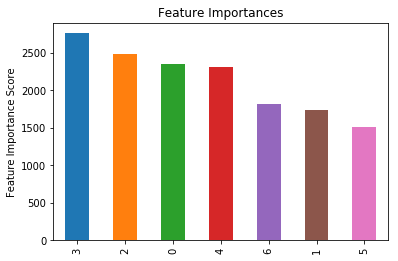

In [13]:
#print the importance score for each viriable
column_name=columns
#feat_imp = pd.Series(bst.get_fscore().values(),index=column_name).sort_values(ascending=False)  
feat_imp = pd.Series(bst.get_fscore().values()).sort_values(ascending=False)  
feat_imp.plot(kind='bar', title='Feature Importances')  
plt.ylabel('Feature Importance Score')  
plt.show()  

In [14]:
pred_prob = bst.predict(xg_test).reshape(test_Y.shape[0], 2)
print pred_prob
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != test_Y) / test_Y.shape[0]
print pred_label[0:20], test_Y[0:20] ,error_rate
print('Test error using softprob = {}'.format(error_rate))

[[0.6260923  0.37390763]
 [0.7457885  0.25421152]
 [0.51482767 0.48517233]
 ...
 [0.7542345  0.24576549]
 [0.6720342  0.32796577]
 [0.43706802 0.562932  ]]
[0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0] [0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0] 0.3440422322775264
Test error using softprob = 0.344042232278


In [15]:
#save the predict probility for each event
#f=open("xgb_predict.txt","wb")
#f1=open("xgb_input.txt","wb")
#pr=np.array(bst.predict(xg_val).reshape(val_Y.shape[0], 2)[:,1])
#np.savetxt(f,pr)
#np.savetxt(f,val_Y)
#np.savetxt(f1,val_X[:,0:2])

In [16]:
pr_test=np.array(bst.predict(xg_test).reshape(test_Y.shape[0], 2))
pr_phsp=np.array(bst.predict(xg_phsp_only).reshape(phsp_only_Y.shape[0], 2))
pr_mctruth=np.array(bst.predict(xg_mctruth_only).reshape(mctruth_only_Y.shape[0], 2))

In [17]:
weight_test=pr_test[:,1]/pr_test[:,0]
weight_phsp=pr_phsp[:,1]/pr_phsp[:,0]
weight_mctruth=pr_mctruth[:,1]/pr_mctruth[:,0]

#save the weight for each event
f=open("xgb_weight.txt","wb")
np.savetxt(f,weight_phsp)

print 'The efficiency is = ',weight_phsp.sum()/weight_mctruth.sum()

The efficiency is =  0.31038764


In [18]:
pr_DIY_truth_all=np.array(bst.predict(xg_DIY_truth_all).reshape(DIY_truth_all_Y.shape[0], 2))
weight_DIY_truth_all=pr_DIY_truth_all[:,1]/pr_DIY_truth_all[:,0]
f=open("xgb_weight_DIY_truth_all.txt","wb")
np.savetxt(f,weight_DIY_truth_all)

In [19]:
#draw_distributions(DIY_truth_all_draw, data_ori_draw,weight_DIY_truth_all,'DIYtruth_target_xgboost.pdf')

In [20]:
#draw_distributions(phsp_ori_draw, data_ori_draw,weight_phsp,'phsp_target_xgboost.pdf')

In [21]:
#draw_distributions(mctruth_ori_draw, data_ori_draw,mctruth_weights,'mctruth_target_ori.pdf')

In [22]:
#draw_distributions(mctruth_ori_draw, data_ori_draw,weight_mctruth,'phsp_target_ori.pdf')

## GBDT

error  = 0.340422322775
Efficient =  0.31353358619282934


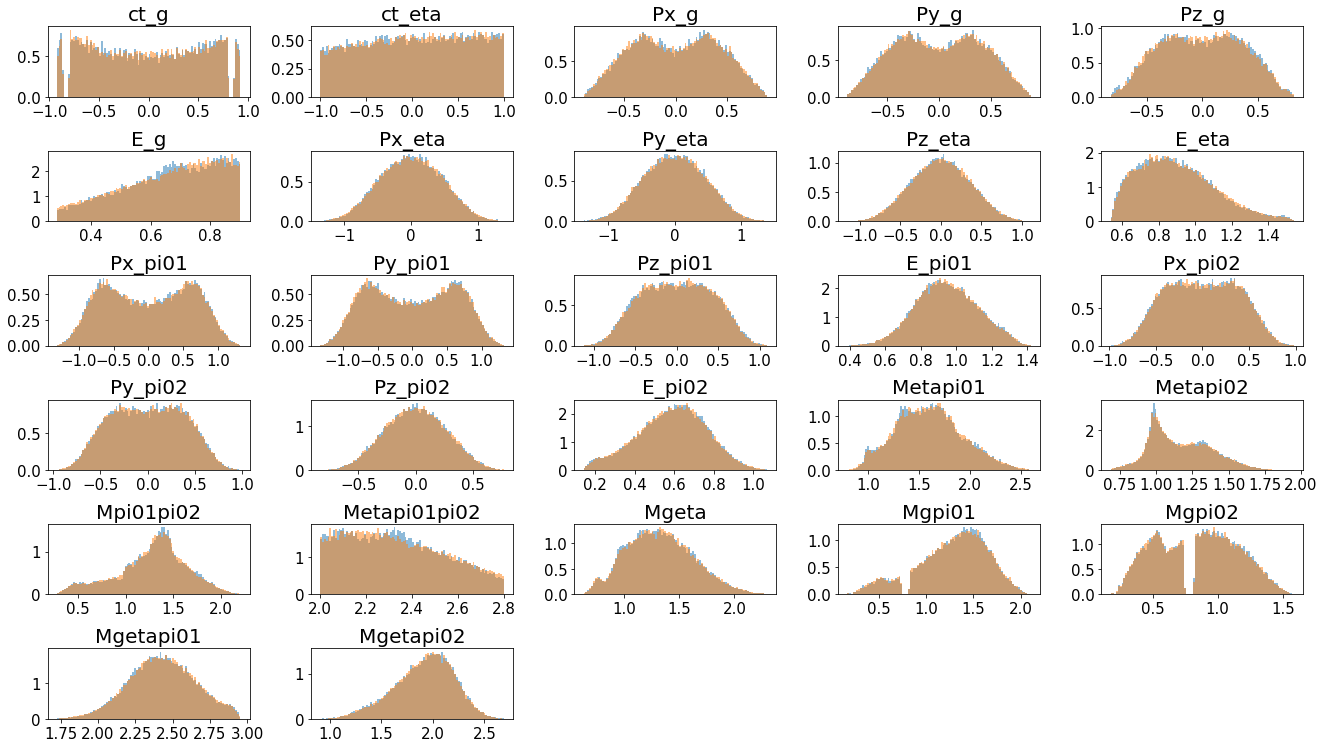

In [23]:
#sklearn GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics

#data_gbdt = numpy.concatenate([original_train, target_train])
#labels_gbdt = numpy.array([0] * len(original_train) + [1] * len(target_train))


Xtr_gbdt, Xts_gbdt, Ytr_gbdt, Yts_gbdt = train_test_split(data_all, labels_all, random_state=42, train_size=0.8)
clf_gbdt = GradientBoostingClassifier().fit(Xtr_gbdt, Ytr_gbdt)

pred_label = np.argmax(clf_gbdt.predict_proba(Xts_gbdt), axis=1)
error_rate_val = np.sum(pred_label != Yts_gbdt) / Yts_gbdt.shape[0]
print('error  = {}'.format(error_rate_val))
    
pr_phsp=np.array(clf_gbdt.predict_proba(phsp_only_X).reshape(phsp_only_Y.shape[0], 2))
pr_mctruth=np.array(clf_gbdt.predict_proba(mctruth_only_X).reshape(mctruth_only_Y.shape[0], 2))
weight_phsp_GBT=pr_phsp[:,1]/pr_phsp[:,0]
weight_mctruth_GBT=pr_mctruth[:,1]/pr_mctruth[:,0]
print "Efficient = ", weight_phsp_GBT.sum()/weight_mctruth_GBT.sum()

draw_distributions(phsp_ori_draw, data_ori_draw,weight_phsp_GBT,'phsp_target_GBT.pdf')

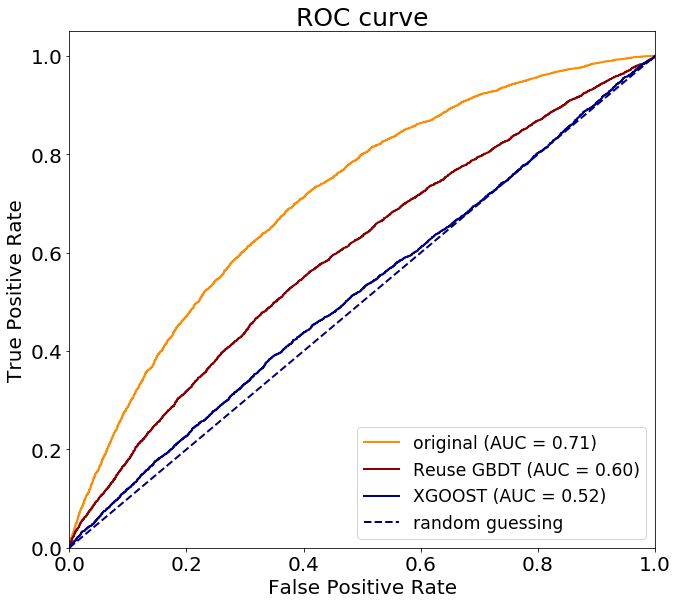

In [24]:
#from hep_ml import reweight
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics

#for paper
#gb_weights_test = reweighter.predict_weights(original_test)

    
data = data_all
labels = labels_all

#get the weight factor for xgb_model
xgb_X = np.array(phsp_train)
xgb_Y = numpy.array([0] * len(xgb_X))
xg_phsp = xgb.DMatrix(xgb_X, label=xgb_Y)
pr_phsp_xgb=np.array(bst.predict(xg_phsp))
weight_xgb=pr_phsp_xgb[:,1]/pr_phsp_xgb[:,0]

#for sklearn gbdt
pr_phsp_gbdt=np.array(clf_gbdt.predict_proba(phsp_train).reshape(phsp_train.shape[0], 2))
#pr_phsp_gbdt=np.array(clf_gbdt.predict_proba(phsp_train))
gbdt_weights_test=pr_phsp_gbdt[:,1]/pr_phsp_gbdt[:,0]
#draw_distributions(phsp_train_draw, data_ori_draw,gbdt_weights_test,'test.pdf')


#new_weights=original_weights_test
#W = numpy.concatenate([new_weights / new_weights.sum() * len(phsp_only_X), [1] * len(data_only_X)])
W = numpy.concatenate([[1] * len(data_train),[1]*len(phsp_train)])
Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.8)
    
clf_ori = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)
fpr_ori, tpr_ori, thresholds_ori = metrics.roc_curve(Yts,clf_ori.predict_proba(Xts)[:, 1])

new_weights=weight_xgb
W = numpy.concatenate([[1] * len(data_train),new_weights / new_weights.sum() * len(phsp_train)])
Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.8)
clf_xgb_t = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(Yts,clf_xgb_t.predict_proba(Xts)[:, 1])

new_weights=gbdt_weights_test
W = numpy.concatenate([ [1] * len(data_train),new_weights / new_weights.sum() * len(phsp_train)])
Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.8)
clf_gbdt_t = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)
fpr_gbdt, tpr_gbdt, thresholds_gbdt = metrics.roc_curve(Yts,clf_gbdt_t.predict_proba(Xts)[:, 1])


#fpr, tpr, thresholds = metrics.roc_curve(Yts,Yts)
plt.figure().set_size_inches(10.5, 9.5)
#plt.plot(fpr_xgb,tpr_xgb,lw=2, color='darkblue',label='xgboost (AUC = %0.2f)' % metrics.auc(fpr_xgb,tpr_xgb))
plt.plot(fpr_ori,tpr_ori,lw=2, color='darkorange',label='original (AUC = %0.2f)' % metrics.auc(fpr_ori,tpr_ori))
plt.plot(fpr_gbdt,tpr_gbdt,lw=2, color='darkred',label='Reuse GBDT (AUC = %0.2f)' % metrics.auc(fpr_gbdt,tpr_gbdt))
plt.plot(fpr_xgb,tpr_xgb,lw=2, color='darkblue',label='XGOOST (AUC = %0.2f)' % metrics.auc(fpr_xgb,tpr_xgb))
plt.plot([0, 1], [0, 1], color='navy',label='random guessing',lw=2,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('ROC curve',fontsize=25)                                                                                                  
plt.legend(loc="lower right",fontsize='xx-large')

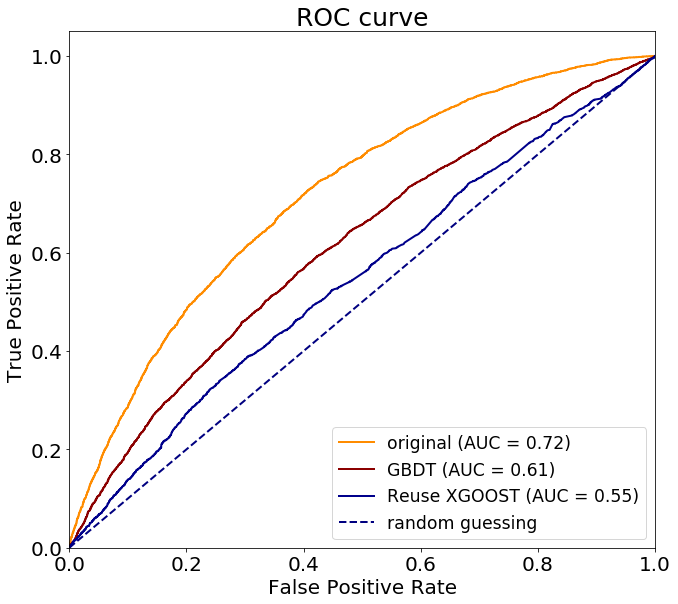

In [25]:
#from hep_ml import reweight
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.cross_validation import train_test_split
#from sklearn.metrics import roc_auc_score
#from sklearn import metrics

#for paper
#gb_weights_test = reweighter.predict_weights(original_test)

    
data = data_all
labels = labels_all

#get the weight factor for xgb_model
xgb_X = np.array(phsp_train)
xgb_Y = numpy.array([0] * len(xgb_X))
xg_phsp = xgb.DMatrix(xgb_X, label=xgb_Y)

pr_phsp_xgb=np.array(bst.predict(xg_phsp))
weight_xgb=pr_phsp_xgb[:,1]/pr_phsp_xgb[:,0]


#for sklearn gbdt
pr_phsp_gbdt=np.array(clf_gbdt.predict_proba(phsp_train).reshape(phsp_train.shape[0], 2))
#pr_phsp_gbdt=np.array(clf_gbdt.predict_proba(phsp_train))
gbdt_weights_test=pr_phsp_gbdt[:,1]/pr_phsp_gbdt[:,0]
#draw_distributions(phsp_train_draw, data_ori_draw,gbdt_weights_test,'test.pdf')


#new_weights=original_weights_test
#W = numpy.concatenate([new_weights / new_weights.sum() * len(phsp_only_X), [1] * len(data_only_X)])
W = numpy.concatenate([[1] * len(data_train),[1]*len(phsp_train)])
Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.8)
    
xgboost_ori = xgb.XGBClassifier().fit(Xtr, Ytr, sample_weight=Wtr)
fpr_ori, tpr_ori, thresholds_ori = metrics.roc_curve(Yts,xgboost_ori.predict_proba(Xts)[:, 1])

new_weights=weight_xgb
W = numpy.concatenate([[1] * len(data_train),new_weights / new_weights.sum() * len(phsp_train)])
Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.8)
xgboost_xgb_t = xgb.XGBClassifier().fit(Xtr, Ytr, sample_weight=Wtr)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(Yts,xgboost_xgb_t.predict_proba(Xts)[:, 1])

new_weights=gbdt_weights_test
W = numpy.concatenate([ [1] * len(data_train),new_weights / new_weights.sum() * len(phsp_train)])
Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.8)
xgboost_gbdt_t = xgb.XGBClassifier().fit(Xtr, Ytr, sample_weight=Wtr)
fpr_gbdt, tpr_gbdt, thresholds_gbdt = metrics.roc_curve(Yts,xgboost_gbdt_t.predict_proba(Xts)[:, 1])


#fpr, tpr, thresholds = metrics.roc_curve(Yts,Yts)
plt.figure().set_size_inches(10.5, 9.5)
#plt.plot(fpr_xgb,tpr_xgb,lw=2, color='darkblue',label='xgboost (AUC = %0.2f)' % metrics.auc(fpr_xgb,tpr_xgb))
plt.plot(fpr_ori,tpr_ori,lw=2, color='darkorange',label='original (AUC = %0.2f)' % metrics.auc(fpr_ori,tpr_ori))
plt.plot(fpr_gbdt,tpr_gbdt,lw=2, color='darkred',label='GBDT (AUC = %0.2f)' % metrics.auc(fpr_gbdt,tpr_gbdt))
plt.plot(fpr_xgb,tpr_xgb,lw=2, color='darkblue',label='Reuse XGOOST (AUC = %0.2f)' % metrics.auc(fpr_xgb,tpr_xgb))
plt.plot([0, 1], [0, 1], color='navy',label='random guessing',lw=2,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('ROC curve',fontsize=25)                                                                                                  
plt.legend(loc="lower right",fontsize='xx-large')

In [39]:
pr_phsp=np.array(bst.predict(xg_phsp_only).reshape(phsp_only_Y.shape[0], 2))
pr_mctruth=np.array(bst.predict(xg_mctruth_only).reshape(mctruth_only_Y.shape[0], 2))
weight_phsp=pr_phsp[:,1]/pr_phsp[:,0]
weight_mctruth=pr_mctruth[:,1]/pr_mctruth[:,0]
print weight_phsp
print weight_mctruth
print "Efficient = ", weight_phsp.sum()/weight_mctruth.sum()

[0.10194699 1.8008631  1.3998995  ... 1.7830148  0.29553714 0.81717485]
[2.0087795  0.8074253  0.12827274 ... 0.36914912 0.9261249  0.08569899]
Efficient =  0.31038764


In [32]:
pr_phsp_new=np.array(xgboost_xgb_t.predict_proba(phsp_only_X))
pr_mctruth_new=np.array(xgboost_xgb_t.predict_proba(mctruth_only_X))

In [40]:
weight_phsp_new=pr_phsp_new[:,1]/pr_phsp_new[:,0]
weight_mctruth_new=pr_mctruth_new[:,1]/pr_mctruth_new[:,0]
print weight_phsp_new
print weight_mctruth_new
print "Efficient = ", weight_phsp_new.sum()/weight_mctruth_new.sum()

[1.0596865  1.0202633  0.9833601  ... 1.1130801  0.93553716 0.9294882 ]
[0.95614755 1.0298822  1.2641693  ... 1.056422   0.9249695  0.8867751 ]
Efficient =  0.3059073


In [43]:
print "Efficient = ", (weight_phsp_new*weight_phsp).sum()/(weight_mctruth_new*weight_mctruth).sum()

 Efficient =  0.31144148
